<a href="https://colab.research.google.com/github/kstoreyf/equivariant-cosmology/blob/main/2021-11-05_toy_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy.stats
import time
from google.colab import drive
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

In [ ]:

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 130
plt.rcParams['savefig.dpi'] = 130

Problem: Given a dark matter only simulation, determine the properties (locations and masses, for now) of the galaxies, as would be found in a full hydrodynamic simulation.

This problem is tricky because baryonic effects move the galaxies and halos around between the DM-only and hydro sims. We will need to use both the local properties and the large-scale environment to make this mapping.

This relationship contains symmetries: for example, if we rotate or translate the entire box, the results should transform accordingly. To enforce this, we use the approach of *equivariant scalars* (Villar+2021). 

For now, we will work with some fake data as proof-of-concept, and train a basic linear regression model and a basic neural network to do this mapping. The features are related to functions of the scalars as defined in Villar+2021. 

### Set up data set

Our input data will be dark matter (DM) particle locations and masses for a given halo.

The output data will be the location and mass of the galaxy that resides in the halo.

See the latex doc for details!

In [ ]:
n_dim = 3 # x,y,z
m_dm = 1 # the mass of each DM particle

drive.mount('/content/drive')
plot_dir = '/content/drive/My Drive/scalars/plots_2021-11-03'
save_plots = False
show_intermediate_plots = False

Mounted at /content/drive


In [ ]:
# beta, gamma:  scales m_true
def generate_halo(n_dim=3, n_particles_main_true=200, n_particles_skew_true=40,
                  skew_amplitude=2.0,
                  N_shape=4, std_shape=1.5,
                  beta=0.1, gamma=-0.02): 
  ### x: dm values
  n_particles_main = np.random.poisson(lam=n_particles_main_true)
  n_particles_skew = np.random.poisson(lam=n_particles_skew_true)
  n_particles = n_particles_main + n_particles_skew

  # Use Wishart distribution for covariance
  # as N_shape-->infinity, cov-->std_shape**2 * I_3 (identity in 3D)
  mean_shape = np.zeros(n_dim)
  cov_shape = std_shape**2 * np.identity(n_dim)
  shape_vectors = [np.random.multivariate_normal(mean=mean_shape, cov=cov_shape) for _ in range(N_shape)]
  cov_true = 1/N_shape * np.sum(np.array([np.outer(sv, sv) for sv in shape_vectors]), axis=0)

  mean_main_true = np.zeros(n_dim)
  x_dm_main = np.random.multivariate_normal(mean=mean_main_true, cov=cov_true, size=n_particles_main)
  mean_skew_true = skew_amplitude*np.random.multivariate_normal(mean=mean_main_true, cov=cov_true) # mean of skewed blob is draw from main distribution, scaled 
  x_dm_skew = np.random.multivariate_normal(mean=mean_skew_true, cov=cov_true, size=n_particles_skew) #rescale the skewed blob to move it closer or farther from main mean
  x_dm = np.concatenate((x_dm_main, x_dm_skew))

  # center all halos on the empirical dm mass distribution
  x_dm_com = np.mean(x_dm, axis=0)
  x_dm -= x_dm_com
  mean_main_true -= x_dm_com
  mean_skew_true -= x_dm_com
  x_dm_main -= x_dm_com
  x_dm_skew -= x_dm_com

  ### y: galaxy values
  condition_number = np.linalg.cond(cov_true) # condition number is ratio of largest to smallest eigenvalues
  #gal_to_dm_ratio = beta * np.log10(condition_number)
  gal_to_dm_ratio = beta * condition_number**gamma
  m_halo = m_dm*n_particles # in arbitrary units
  m_gal = gal_to_dm_ratio*m_halo

  x_gal = mean_main_true # galaxy position is center of main distribution

  halo_dict = {'x_dm': x_dm,
               'mean_main': mean_main_true, 'mean_skew': mean_skew_true, 
               'x_dm_main': x_dm_main, 'x_dm_skew': x_dm_skew,
               'x_gal': x_gal, 'm_gal': m_gal
               }

  return halo_dict

In [ ]:
def plot_halos(halo_dicts, nrows, ncols, titles):
  sub_width, sub_height = 4, 4
  fig, axarr = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(sub_width*ncols, sub_height*nrows))

  count = 0
  for i in range(nrows):
    for j in range(ncols):
      #x_dm, x_gal = xs_dm[count], xs_gal[count]
      halo = halo_dicts[count]
      ax = axarr[i,j]

      x_dm_main = halo['x_dm_main']
      x_dm_skew = halo['x_dm_skew']
      x_gal = halo['x_gal']
      mean_main = halo['mean_main']
      mean_skew = halo['mean_skew']

      ax.scatter(x_dm_main[:,0], x_dm_main[:,1], color='skyblue', s=4, label='DM particles (main)', alpha=0.5)
      if len(x_dm_skew)>0:
        ax.scatter(x_dm_skew[:,0], x_dm_skew[:,1], color='orchid', s=4, label='DM particles (skew)', alpha=0.5)

      ax.scatter(x_gal[0], x_gal[1], color='orange', s=200, marker='*', label='galaxy', alpha=0.8)
      ax.scatter(mean_main[0], mean_main[1], color='darkblue', s=150, marker='+', label='true mean (main)', alpha=0.8)
      if len(x_dm_skew)>0:
        ax.scatter(mean_skew[0], mean_skew[1], color='purple', s=150, marker='+', label='true mean (skew)', alpha=0.8)


      ax.axvline(0, color='k', lw=0.5)
      ax.axhline(0, color='k', lw=0.5)

      ax.set_title(titles[count])
      ax.set_aspect('equal')
      ax.locator_params(axis="x", nbins=5)
      ax.locator_params(axis="y", nbins=5)

      if j==0:
        ax.set_ylabel('y')
      if i==nrows-1:
        ax.set_xlabel('x')
      lim = 10
      ax.set_xlim(-1*lim, lim)
      ax.set_ylim(-1*lim, lim)
      
      count += 1
    
  axarr[0,0].legend(fontsize=8, loc='best')


Test out halo generation with diff skewness values

In [ ]:
if show_intermediate_plots:
  np.random.seed(42)
  nrows, ncols = 2, 3
  nplot = nrows*ncols
  skew_amplitudes = np.linspace(0, 3, nplot)
  #skew_amplitudes = np.zeros(nplot)
  #skew_amplitudes = np.ones(nplot)

  halo_dicts = []
  for i in range(nplot):
    halo_dict = generate_halo(skew_amplitude=skew_amplitudes[i], n_particles_skew_true=100)
    halo_dicts.append(halo_dict)
  titles = [f"Skewness {skew:.3}" for skew in skew_amplitudes]
  mean_labels = [r'$\mu_\mathrm{true,main}$', r'$\mu_\mathrm{true,skew}$']
  plot_halos(halo_dicts, nrows=nrows, ncols=ncols, titles=titles)

Generate data:

In [ ]:
# save_tag = '_mlinear_skewnone'
# beta, gamma = 0.01, 0.0 # linear mass relationship
# fraction_skew_particles = 0.0

save_tag = '_mgamma-0.02_skewfrac0.25'
beta, gamma = 0.1, -0.02 # scales m_true
fraction_skew_particles = 0.25

np.random.seed(40) # 40 has less-catastrophic outliers

n_halos_tot = 5000 # these will be later split into training and test
frac_test = 0.2 # fraction of n_halos_tot that will belong to test set; rest to training set

# set up data structures
x_data = []
y_scalar = np.empty(n_halos_tot) # 1 mass dimension
y_vector_rolled = np.empty((n_halos_tot, n_dim)) # predict 3 spatial dimensions

# set parameters
n_particles_total_true = 1000
n_particles_main_true = int(n_particles_total_true*(1-fraction_skew_particles))
n_particles_skew_true = int(n_particles_total_true*fraction_skew_particles)

skew_amplitude = 1.0

N_shape = 4 
std_shape = 1.5

halo_dicts = []

for nh in range(n_halos_tot):

  halo_dict = generate_halo(n_dim=n_dim, n_particles_main_true=n_particles_main_true, n_particles_skew_true=n_particles_skew_true,
                                      skew_amplitude=skew_amplitude, 
                                      N_shape=N_shape, std_shape=std_shape,
                                      beta=beta, gamma=gamma)
  halo_dicts.append(halo_dict)

  x_data.append(halo_dict['x_dm'])
  y_scalar[nh] = halo_dict['m_gal']
  y_vector_rolled[nh,:] = halo_dict['x_gal']

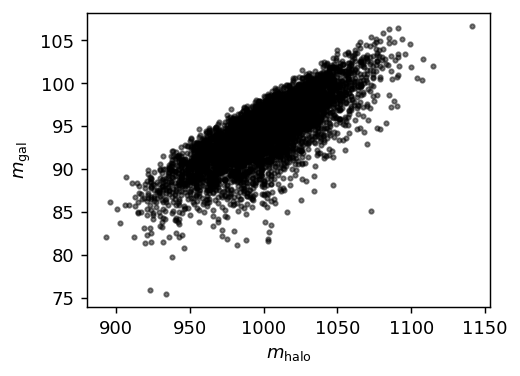

In [ ]:
plt.figure(figsize=(4,3))
ms_halo = [x_t.shape[0]*m_dm for x_t in x_data]
plt.scatter(ms_halo, y_scalar, color='k', s=6, alpha=0.5)
plt.xlabel(r'$m_\mathrm{halo}$')
plt.ylabel(r'$m_\mathrm{gal}$')
if save_plots:
  plt.savefig(f'{plot_dir}/mgal_v_mhalo{save_tag}.pdf', bbox_inches='tight')

Plot some of the halos:

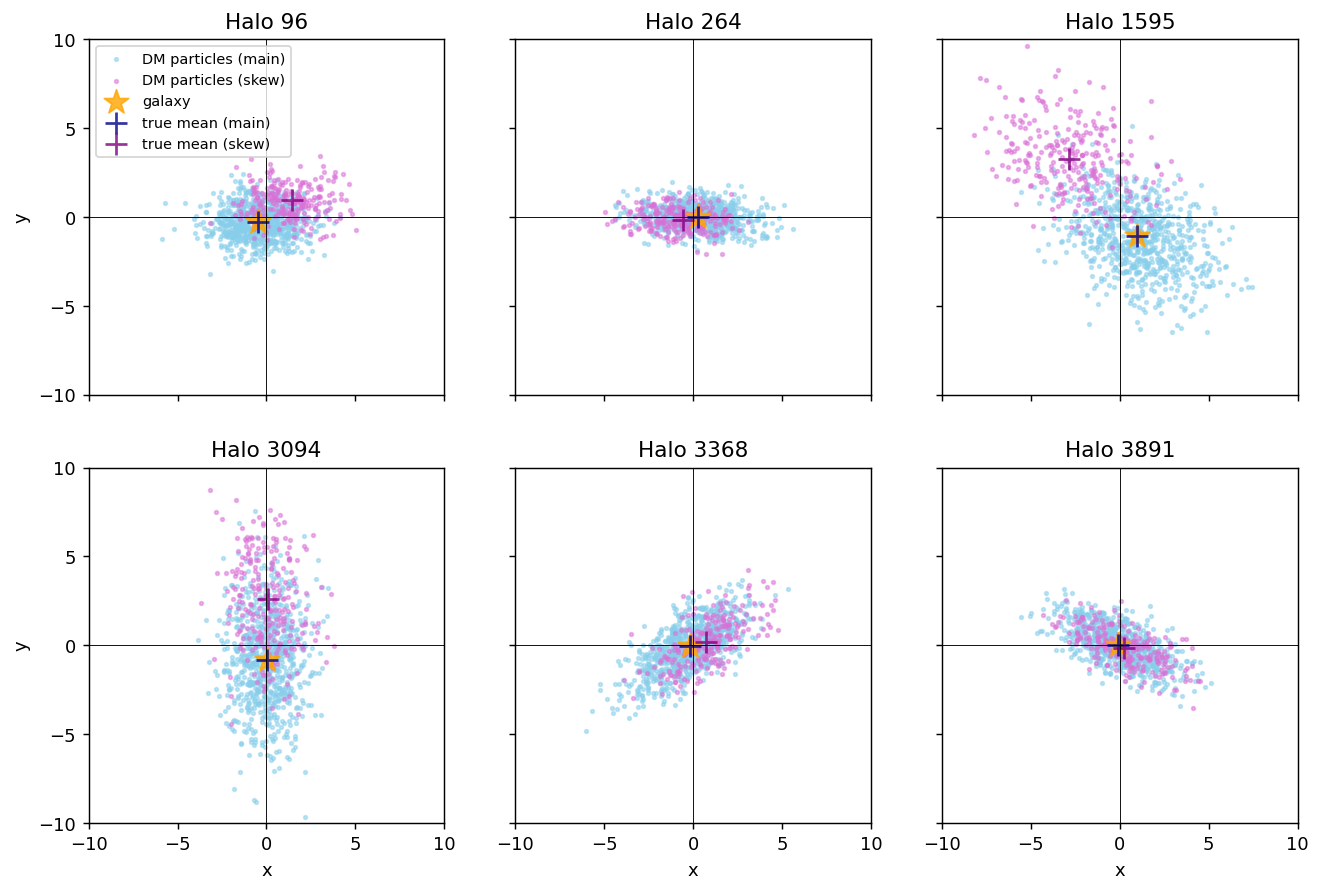

In [ ]:
nrows, ncols = 2, 3
nplot = nrows*ncols
nhs = np.random.randint(0, n_halos_tot, size=nplot)
np.random.seed(42)
nhs = sorted(nhs)
titles = [f"Halo {nh}" for nh in nhs]
halos = [halo_dicts[nh] for nh in nhs]
plot_halos(halos, nrows=nrows, ncols=ncols, titles=titles)
save_fn = f'halo_samples{save_tag}.pdf'
if save_plots:
  plt.savefig(f"{plot_dir}/{save_fn}", bbox_inches='tight')

### Compute the scalar, vector, tensor etc features

$t_{ln} = \sum_i m_i W_n(r) x_i^{\otimes l}$

- $t_{0n}$ are scalars
- $t_{1n}$ are vectors
- $t_{2n}$ are tensors
- etc

Define some functions:

In [ ]:
r_edges = np.array([0,1,2,4,8,16])
print(r_edges)
n_rbins = len(r_edges) - 1

def W(n, r):
  if r_edges[n] <= r < r_edges[n+1]:
    return 1
  else:
    return 0

def W_vec(n_arr, rs):
  inds = np.digitize(rs, r_edges)
  Ws = np.zeros((n_rbins, len(rs)))
  for k, n in enumerate(n_arr):
    idxs_r_n = np.where(inds==k+1) #+1 because bin 0 means outside of range
    Ws[k,idxs_r_n] = 1
  return Ws 

def x_outer(l, delta_x):
  if l==0:
    return 1
  else:
    return reduce(np.multiply.outer, [delta_x]*l)

def x_outer_vec(l, delta_x_arr, x_outers_prev):
  # can't figure out how to vectorize better
  if l==0:
    return np.ones(len(delta_x_arr))
  if l==1:
    return delta_x_arr
  else:
    x_outers = np.empty([len(delta_x_arr)] + [n_dim]*l)
    for i, delta_x in enumerate(delta_x_arr):
      x_outers[i,:] = np.multiply.outer(x_outers_prev[i], delta_x)
    return x_outers

[ 0  1  2  4  8 16]


Compute all features (see latex doc):

In [ ]:
l_arr = np.array([0, 1, 2, 3])
n_arr = np.arange(n_rbins)

def get_tensors_slow(delta_x_data_halo):
  N, n_dim_from_data = delta_x_data_halo.shape
  m_total = N*m_dm
  assert n_dim_from_data == n_dim, f"Number of dimensions in data {n_dim_from_data} does not equal global n_dim, {n_dim}!"
  t_arrs = []
  t_normed_arrs = []
  for j, l in enumerate(l_arr):
    t_arr = np.empty([len(n_arr)] + [n_dim]*l)
    t_normed_arr = np.empty([len(n_arr)] + [n_dim]*l)
    for k, n in enumerate(n_arr):
      t_ln = 0
      t_normalization_ln = 0
      for i in range(N):
        r = np.linalg.norm(delta_x_data_halo[i])
        window_val = W(n, r)
        t_ln += window_val * x_outer(l, delta_x_data_halo[i])
        t_normalization_ln += window_val
      t_arr[k,...] = t_ln * m_dm # can pull the mass multiplier out here bc equal mass particles 
      #t_normed_arr[k,...] = t_ln / t_normalization_ln if t_normalization_ln != 0 else 0
      t_normed_arr[k,...] = t_ln * m_dm / m_total # normalize features by total mass
    t_arrs.append(t_arr)
    t_normed_arrs.append(t_normed_arr)
  return t_arrs, t_normed_arrs

def get_tensors(delta_x_data_halo):
  N, n_dim_from_data = delta_x_data_halo.shape
  m_total = N*m_dm
  assert n_dim_from_data == n_dim, f"Number of dimensions in data {n_dim_from_data} does not equal global n_dim, {n_dim}!"
  t_arrs = []
  t_normed_arrs = []

  # vectorized for all particles N
  rs = np.linalg.norm(delta_x_data_halo, axis=1)
  assert len(rs) == N, "rs should have length N!"
  window_vals = W_vec(n_arr, rs)

  x_outers_prev = None
  for j, l in enumerate(l_arr):
    t_arr = np.empty([len(n_arr)] + [n_dim]*l)
    t_normed_arr = np.empty([len(n_arr)] + [n_dim]*l)

    #x_outers = x_outer_vec(l, delta_x_data_halo)
    x_outers = x_outer_vec(l, delta_x_data_halo, x_outers_prev)

    for k, n in enumerate(n_arr):
      t_ln = np.sum( window_vals[k,:] * x_outers.T, axis=-1)
      t_normalization_ln = np.sum(window_vals[k,:])

      t_arr[k,...] = t_ln * m_dm # can pull the mass multiplier out here bc equal mass particles 
      #t_normed_arr[k,...] = t_ln / t_normalization_ln if t_normalization_ln != 0 else 0
      t_normed_arr[k,...] = t_ln * m_dm / m_total

    t_arrs.append(t_arr)
    t_normed_arrs.append(t_normed_arr)

    x_outers_prev = x_outers

  return t_arrs, t_normed_arrs  

Note that t_arr is an array of form [[t_00, t_01, .. t_0N], [t_10, t_11, ... , t_1N], ... ] where N is N_bins; these have shape [(N,) (N,3), (N,3,3), ...]

In [ ]:
t_arrs_halos = []
t_normed_arrs_halos = []
for nh in range(n_halos_tot):
  x_data_halo = x_data[nh]
  # Subtract off fiducial point for each halo
  # s = time.time()
  # t_arrs_slow, t_normed_arrs_slow = get_tensors_slow(delta_x_halo)
  # print(f"slow: {time.time() - s} s")
  # s = time.time()
  t_arrs, t_normed_arrs = get_tensors(x_data_halo)
  #print(f"fast: {time.time() - s} s")

  #for j in range(len(l_arr)):
  #  assert np.allclose(t_arrs[j], t_arrs_slow[j], rtol=1e-05), f"fast version not same for l={l_arr[j]}!"
  t_arrs_halos.append(t_arrs)
  t_normed_arrs_halos.append(t_normed_arrs)

In [ ]:
print([t.shape for t in t_arrs_halos[0]])
print([t.shape for t in t_normed_arrs_halos[0]])

[(5,), (5, 3), (5, 3, 3), (5, 3, 3, 3)]
[(5,), (5, 3), (5, 3, 3), (5, 3, 3, 3)]


Let's plot the features and see how they correspond to the desired outputs!

In [ ]:
color_mass = np.linspace(min(y_scalar), max(y_scalar), len(y_scalar))
color_mass_norm = matplotlib.colors.Normalize(vmin=min(y_scalar), vmax=max(y_scalar))

color_x = np.linspace(min(y_vector_rolled[:,0]), max(y_vector_rolled[:,0]), len(y_vector_rolled[:,0]))
color_x_norm = matplotlib.colors.Normalize(vmin=min(y_vector_rolled[:,0]), vmax=max(y_vector_rolled[:,0]))

cmap = matplotlib.cm.get_cmap('plasma')

Plot $l=0$ features, which correspond to the mass in each radial bin:

In [ ]:
if show_intermediate_plots:
  l = 0
  r_edges_nozeros = np.concatenate(([0.5], r_edges[1:]))
  r_avg = 10**(0.5*(np.log10(r_edges_nozeros[:-1]) + np.log10(r_edges_nozeros[1:])))

  plt.figure(figsize=(4,3))
  for nh in range(n_halos_tot):
    plt.plot(r_avg, t_arrs_halos[nh][l], ls='-', marker='.',  color=cmap(color_mass_norm(y_scalar[nh])), alpha=0.5)

  sm = plt.cm.ScalarMappable(cmap=cmap, norm=color_mass_norm)
  plt.colorbar(sm, label=r'$m_\mathrm{gal}$')

  plt.xscale('log')
  plt.xlabel(r'$r_n$')
  plt.ylabel(r'$t_{0n}$')

Plot the first value of the $l=1$ feature vectors, which correspond to the x direction weight in each radial bin:

In [ ]:
if show_intermediate_plots:
  r_edges_nozeros = np.concatenate(([0.5], r_edges[1:]))
  r_avg = 10**(0.5*(np.log10(r_edges_nozeros[:-1]) + np.log10(r_edges_nozeros[1:])))
  
  plt.figure(figsize=(4,3))
  for nh in range(n_halos_tot):
    plt.plot(r_avg, t_arrs_halos[nh][1][:,0], ls='-', marker='.',  color=cmap(color_x_norm(y_vector_rolled[nh,0])), alpha=0.5)

  sm = plt.cm.ScalarMappable(cmap=cmap, norm=color_x_norm)
  plt.colorbar(sm, label=r'$x_\mathrm{gal}$')
  plt.xscale('log')

  plt.xlabel(r'$r_n$')
  plt.ylabel(r'$t_{1n,x}$')

In [ ]:
if show_intermediate_plots:
  plt.figure(figsize=(4,6))
  ax = plt.gca()
  masses_total_from_ts = np.empty(n_halos_tot)
  for nh in range(n_halos_tot):
    masses_total_from_ts[nh] = np.sum([t_arrs_halos[nh][0][n] for n in n_arr])
  masses_dm_total = [m_dm*len(halo_dict['x_dm']) for halo_dict in halo_dicts]
  ax.scatter(masses_total_from_ts, y_scalar, color='k', s=6, label='$m_\mathrm{gal}$')
  ax.scatter(masses_total_from_ts, masses_dm_total, color='purple', s=6, label='$m_\mathrm{halo}$')

  ax.set_xlabel(r'$\Sigma_n t_{0n}$')
  ax.set_ylabel(r'$m_\mathrm{gal}, \. m_\mathrm{halo}$')
  #ax.set_aspect('equal')

  ax.legend()

In [ ]:
if show_intermediate_plots:
  # this is showing that for any n, t_1n / t_normed_1n = [sum(t_0) over n] = total mass
  plt.figure(figsize=(4,4))
  ax = plt.gca()

  ts_1n = np.empty((n_halos_tot, len(n_arr)))
  ts_normled_1n = np.empty((n_halos_tot, len(n_arr)))
  ts_0n = np.empty((n_halos_tot, len(n_arr)))

  for nh in range(n_halos_tot):
    masses_total_from_ts[nh] = np.sum([t_arrs_halos[nh][0][n] for n in n_arr])
  
  dim = 0 #x
  for n in n_arr:
    for nh in range(n_halos_tot):
      ts_1n[nh,n] = t_arrs_halos[nh][1][n,dim]
      ts_normled_1n[nh,n] = t_normed_arrs_halos[nh][1][n,dim]
      ts_0n[nh,n] = t_arrs_halos[nh][0][n]
  
  print(ts_1n.shape)
  for n in n_arr:
    plt.scatter(masses_total_from_ts, ts_1n[:,n]/ts_normled_1n[:,n], s=6)

  plt.xlabel(r'$t_{1n,x} / t_{1n,x,\mathrm{normed}}$')
  plt.ylabel(r'$\Sigma_n t_{0n}$')
  ax.set_aspect('equal')

In [ ]:
if show_intermediate_plots:
  plt.figure(figsize=(4,4))
  ax = plt.gca()
  dim = 0 # x coord
  CoM_from_tensors_arr = np.empty(n_halos_tot)
  x_dm_means = np.array([np.mean(halo_dict['x_dm'], axis=0) for halo_dict in halo_dicts])
  for nh in range(n_halos_tot):
    # t_normed_arrs_halos[nh][1][n,dim] (l=1) are the centers of mass in each shell,
    # normalized by the total mass of the halo.
    # to find the overall center of mass, we just need to sum these:
    CoM_from_tensors_arr[nh] = np.sum([t_normed_arrs_halos[nh][1][n,dim] for n in n_arr])
    
  plt.scatter(CoM_from_tensors_arr, y_vector_rolled[:,dim], color='k', s=6, label=r'$x_\mathrm{gal}$')
  plt.scatter(CoM_from_tensors_arr, x_dm_means[:,dim], color='purple', s=6, label=r'$\bar{x}_\mathrm{dm}$')

  plt.xlabel(r'$\Sigma_n t_{1n,x} \mathrm{(normed)}$')
  plt.ylabel(r'$x_\mathrm{gal}, \. \bar{x}_\mathrm{dm}$')
  plt.legend()

### Compute contracted features

Details in latex doc!

Scalar, features:

\begin{array}{l|l|l|l|l|l}
name & vector not. & summation not. & $O(m)$ & $O(x)$ & \# distinct \\
\hline
$s_1$ & $t_{0n}$ & $t_{0n}$ & 1 & 0 & $\N{bins}$ \\
$s_2$ & $t_{0n} \, t_{0n'}$ & $t_{0n} \, t_{0n'}$ & 2 & 0 & $\N{bins}(\N{bins}-1)$ \\
$s_3$ & $t_{0n} \, t_{0n'} \, t_{0n''}$ & $t_{0n} \, t_{0n'} \, t_{0n''}$ & 3 & 0 &  \\
$s_4$ & $\mathrm{Tr}(t_{2n})$ & $[t_{2n}]_{jj}$ & 1 & 2 & \\
$s_5$ & $t_{1n}\T \cdot t_{1n'}$ & $[t_{1n}]_j \, [t_{1n'}]_j$ & 2 & 2 & \\
$s_6$ & $t_{0n} \, \mathrm{Tr}(t_{2n'})$ & $t_{0n} \, [t_{2n'}]_{jj}$ & 2 & 2 & \\
$s_7$ & $t_{0n} \, (t_{1n'}\T \cdot t_{1n''})$ & $t_{0n} \, [t_{1n'}]_j \, [t_{1n''}]_j$ & 3 & 2 & \\
$s_8$ & $t_{0n} \, t_{0n'} \, \mathrm{Tr}(t_{2n''})$ & $t_{0n} \, t_{0n'} \, [t_{2n''}]_{jj}$ & 3 & 2 & \\
\end{array}


In [ ]:
def featurize_scalars(tensor_arr):
  t_0, t_1, t_2 = tensor_arr[:3] #only need up to l=2 for now

  scalar_features = []
  
  scalar_features.append( 1 ) # s0
  for n0 in n_arr:
    scalar_features.append( t_0[n0] ) # s1
    scalar_features.append( np.einsum('jj', t_2[n0]) ) # s4
    for n1 in n_arr:
      scalar_features.append( t_0[n0] * t_0[n1] ) # s2
      scalar_features.append( np.einsum('j,j', t_1[n0], t_1[n1]) ) # s5 
      scalar_features.append( t_0[n0] * np.einsum('jj', t_2[n1]) ) # s6
      for n2 in n_arr:
        scalar_features.append( t_0[n0] * t_0[n1] * t_0[n2] ) # s3
        scalar_features.append( t_0[n0] * np.einsum('j,j', t_1[n1], t_1[n2]) ) # s7
        scalar_features.append( t_0[n0] * t_0[n1] * np.einsum('jj', t_2[n2]) ) # s8

  return scalar_features

Vector features: 

\begin{array}{l|l|l|l|l|l}
name & vector not. & summation not. & $O(m)$ & $O(x)$ & \# distinct \\
\hline
$v_1$ & $t_{1n}$ & $[t_{1n'}]_k$ & 1 & 1 & $\N{bins}$ \\
$v_2$ & $t_{0n} \, t_{1n'}$ & $t_{0n} [t_{1n'}]_k$ & 2 & 1 & \\
$v_3$ & $t_{0n} \, t_{0n'} \, t_{1n''}$ & $t_{0n} \, t_{0n'} \, [t_{1n''}]_k$ & 3 & 1 \\
$v_4$ &  & $[t_{3n}]_{jjk}$ & 1 & 3 & \\
$v_5$ &  & $t_{0n} \, [t_{3n'}]_{jjk}$ & 2 & 3 & \\
$v_6$ & $\mathrm{Tr}(t_{2n}) \, t_{1n'}$ & $[t_{2n}]_{jj} \, [t_{1n'}]_k$ & 2 & 3 & \\
$v_7$ & $t_{2n} \cdot t_{1n'}$ & $[t_{2n}]_{jk} \, [t_{1n'}]_j$ & 2 & 3 & \\
$v_8$ &  & $t_{0n} \, t_{0n'} \, [t_{3n''}]_{jjk} $ & 3 & 3 & \\
$v_9$ & $(t_{1n}\T \cdot t_{1n'}) \, t_{1n''}$ & $[t_{1n}]_j \, [t_{1n'}]_j \, [t_{1n''}]_k$ & 3 & 3 & \\
$v_{10}$ & $t_{0n} \, \mathrm{Tr}(t_{2n'}) \, t_{1n''}$ & $t_{0n} \, [t_{2n'}]_{jj} \, [t_{1n''}]_k$ & 3 & 3 & \\
$v_{11}$ & $t_{0n} \, (t_{2n'} \cdot t_{1n''})$ & $t_{0n} \, [t_{2n'}]_{jk} \, [t_{1n''}]_j$ & 3 & 3 & \\
\end{array}

In [ ]:
def featurize_vectors(tensor_arr):#, tensor_normed_arr):
  t_0, t_1, t_2, t_3 = tensor_arr[:4] #only need up to l=3 for now
  #t_normed_0, t_normed_1, t_normed_2, t_normed_3 = tensor_normed_arr[:4]

  vector_features = []

  vector_features.append( np.ones(n_dim) ) # v0
  for n0 in n_arr:
    vector_features.append( t_1[n0] ) # v1
    #vector_features.append( np.nan_to_num(t_1[n0] / t_normed_1[n0]) ) # v1 normed (for l=1, normalize out the mass)
    vector_features.append( np.einsum('jjk', t_3[n0]) ) # v4
    for n1 in n_arr:
      vector_features.append( t_0[n0] * t_1[n0] ) # v2
      vector_features.append( t_0[n0] * np.einsum('jjk', t_3[n1]) ) # v5
      vector_features.append( np.einsum('jj,k', t_2[n0], t_1[n1]) ) # v6
      vector_features.append( np.einsum('jk,j', t_2[n0], t_1[n1]) ) # v7
      for n2 in n_arr:
        vector_features.append( t_0[n0] * t_0[n1] * t_1[n2] ) # v3
        vector_features.append( t_0[n0] * t_0[n1] * np.einsum('jjk', t_3[n2]) ) # v8
        vector_features.append( np.einsum('j,j,k', t_1[n0], t_1[n1], t_1[n2]) ) # v9
        vector_features.append( t_0[n0] * np.einsum('jj,k', t_2[n1], t_1[n2]) ) # v10
        vector_features.append( t_0[n0] * np.einsum('jk,j', t_2[n1], t_1[n2]) ) # v11

  return vector_features

In [ ]:
x_scalar_features = []
x_vector_features = []
for nh in range(n_halos_tot):
  x_scalar_features.append(featurize_scalars(t_arrs_halos[nh]))
  #x_vector_features.append(featurize_vectors(t_arrs_halos[nh], t_normed_arrs_halos[nh]))
  x_vector_features.append(featurize_vectors(t_normed_arrs_halos[nh]))
x_scalar_features = np.array(x_scalar_features)
x_vector_features = np.array(x_vector_features)

In [ ]:
def unroll_array(arr):
  # shape (N, n_feat, n_dim) to (N*n_dim, n_feat)
  # ... indexes all previous dimensions with :
  arr_unrolled = np.vstack([arr[...,d] for d in range(n_dim)])
  return arr_unrolled

def unroll_array_2d(arr):
  # shape (N, n_dim) to (N*n_dim)
  arr_unrolled = np.hstack([arr[:,d] for d in range(n_dim)])
  return arr_unrolled

def roll_array(arr):
  # shape (N*n_dim) to (N, n_dim)
  assert arr.shape[0] % n_dim == 0, "Unrolled vector shape must be a multiple of n_dim!"
  N = int( arr.shape[0] / n_dim )
  arr_rolled = np.array([arr[d*N:(d+1)*N] for d in range(n_dim)]).T
  return arr_rolled

In [ ]:
x_scalar = x_scalar_features
x_vector = unroll_array(x_vector_features)
y_vector = unroll_array_2d(y_vector_rolled)

print(x_scalar_features.shape)
print(x_scalar.shape)
print(x_vector_features.shape)
print(x_vector.shape)
print(y_scalar.shape)
print(y_vector_rolled.shape)
print(y_vector.shape)

(5000, 461)
(5000, 461)
(5000, 736, 3)
(15000, 736)
(5000,)
(5000, 3)
(15000,)


In [ ]:
check_rolling_method = False
if check_rolling_method:
  # check rolling method
  b_rolled = np.arange(0, 5*4*3).reshape((5,4,3))
  print("b rolled (orig)")
  print(b_rolled.shape)
  print(b_rolled)
  b_unrolled = unroll_array(b_rolled)
  print("b unrolled")
  print(b_unrolled.shape)
  print(b_unrolled)

  c_unrolled = np.arange(0, 5*3).reshape((5*3))
  print("c unrolled (orig)")
  print(c_unrolled.shape)
  print(c_unrolled)
  c_rerolled = roll_array(c_unrolled)

  print("c rerolled")
  print(c_rerolled.shape)
  print(c_rerolled)

  c_reunrolled = unroll_array_2d(c_rerolled)
  print("c unrerolled")
  print(c_unrolled.shape)
  print(c_unrolled)

### Plot SVD of design matrix:

In [ ]:
u, s, vh = np.linalg.svd(x_scalar)
print(u.shape, s.shape, vh.shape)

(5000, 5000) (461,) (461, 461)


(5000, 461)
(461,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


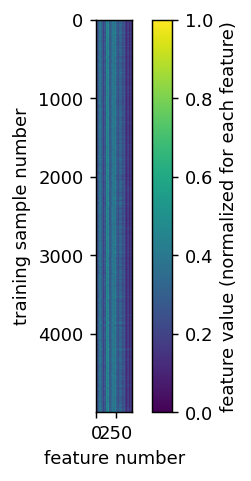

In [ ]:
print(x_scalar.shape)
plt.figure(figsize=(5,4))
x_scalar_mins = np.min(x_scalar, axis=0)
print(x_scalar_mins.shape)
x_scalar_maxs = np.max(x_scalar, axis=0)
x_scalar_normed = (x_scalar - x_scalar_mins)/(x_scalar_maxs - x_scalar_mins)

im = plt.imshow(x_scalar_normed)
plt.xlabel('feature number')
plt.ylabel('training sample number')
plt.colorbar(im, fraction=0.046, pad=0.04, label='feature value (normalized for each feature)')

Text(0, 0.5, 'singular values')

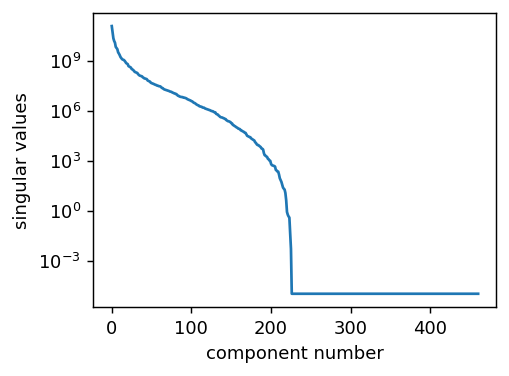

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(s)
plt.yscale('log')
plt.xlabel('component number')
plt.ylabel('singular values')

### Prep data for training/testing: split & scale

In [ ]:
x_scalar_train, x_scalar_test, y_scalar_train, y_scalar_test = train_test_split(x_scalar, y_scalar, test_size=frac_test, random_state=42)
x_vector_train, x_vector_test, y_vector_train, y_vector_test = train_test_split(x_vector, y_vector, test_size=frac_test, random_state=42)
n_train = len(x_scalar_train)
n_test = len(x_scalar_test)
print(n_train, n_test)

4000 1000


### Train and test linear regressor

Use numpy's leastsq function, because it will handle duplicates in the features (np.solve will not) 

In [ ]:
# solves b = ax (or, y = A theta); inputs are a, b (or, A, y)
# A, design matrix, is x here (features)
res_scalar = np.linalg.lstsq(x_scalar_train, y_scalar_train)
theta_scalar = res_scalar[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
rank = res_scalar[2] 
print("rank:", rank)
print("n_feat:", x_scalar_features.shape[1])
assert theta_scalar.shape[0] == x_scalar_features.shape[1], 'Number of coefficients from theta vector should equal number of features!'

rank: 225
n_feat: 461


In [ ]:
y_scalar_pred = x_scalar_test @ theta_scalar

In [ ]:
res_vector = np.linalg.lstsq(x_vector_train, y_vector_train)
theta_vector = res_vector[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [ ]:

rank = res_vector[2] 
print("rank:", rank)
print("n_feat:", x_vector_features.shape[1])
assert theta_vector.shape[0] == x_vector_features.shape[1], 'Number of coefficients from theta vector should equal number of features!'

rank: 388
n_feat: 736


In [ ]:
y_vector_pred = x_vector_test @ theta_vector
y_vector_pred_rolled = roll_array(y_vector_pred) 
y_vector_test_rolled = roll_array(y_vector_test)

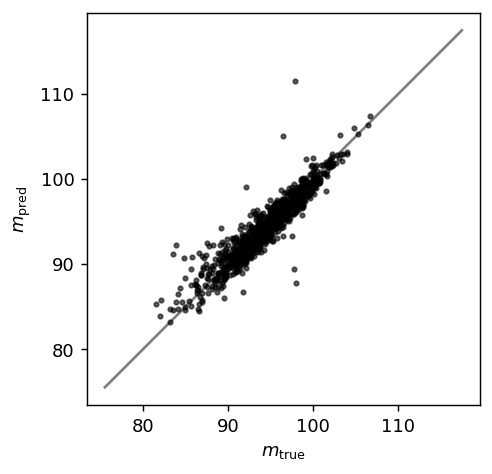

In [ ]:
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
plt.scatter(y_scalar_test, y_scalar_pred, color='k', s=6, alpha=0.6)
ax.set_aspect('equal')
m_minmin = min(min(y_scalar_test), min(y_scalar_pred))
m_maxmax = max(max(y_scalar_test), max(y_scalar_pred))
m_spread = m_maxmax - m_minmin

true_line = np.linspace(m_minmin-0.2*m_spread, m_maxmax+0.2*m_spread)
plt.plot(true_line, true_line, color='grey', zorder=0)
plt.xlabel(r'$m_\mathrm{true}$')
plt.ylabel(r'$m_\mathrm{pred}$')
save_fn = f'mass_recovery{save_tag}.pdf'
if save_plots:
  plt.savefig(f"{plot_dir}/{save_fn}", bbox_inches='tight')

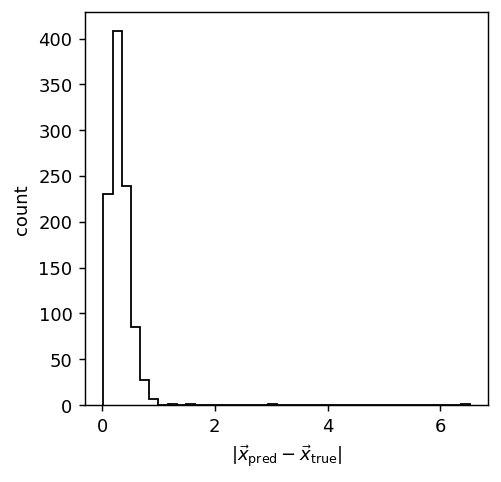

In [ ]:
plt.figure(figsize=(4,4))
delta_r_pred = np.linalg.norm(y_vector_test_rolled - y_vector_pred_rolled, axis=1)
plt.hist(delta_r_pred, bins=40, histtype='step', color='k')
plt.xlabel(r'|$\vec{x}_\mathrm{pred} - \vec{x}_\mathrm{true}$|')
plt.ylabel('count')
save_fn = f'x_distance_recovery{save_tag}.pdf'
if save_plots:
  plt.savefig(f"{plot_dir}/{save_fn}", bbox_inches='tight')

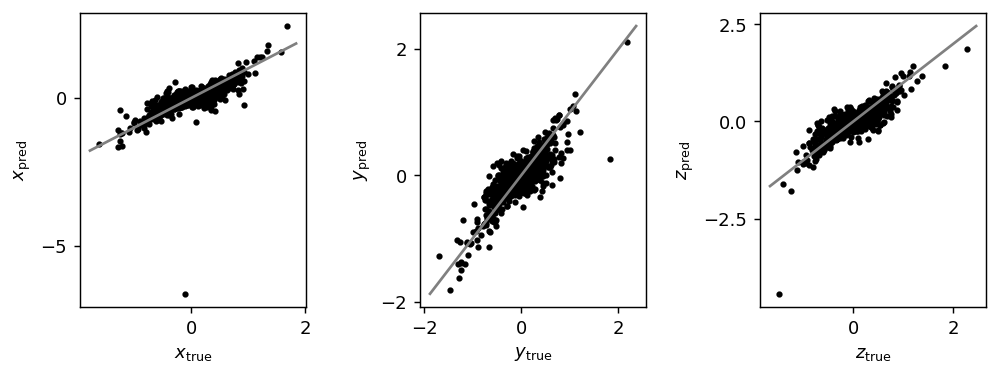

In [ ]:
fig, axarr = plt.subplots(1,3,figsize=(9,3))
plt.subplots_adjust(wspace=0.5)
ax_x = axarr[0]
ax_y = axarr[1]
ax_z = axarr[2]

ax_x.scatter(y_vector_test_rolled[:,0], y_vector_pred_rolled[:,0], color='k', s=6)
ax_x.set_xlabel(r'$x_\mathrm{true}$')
ax_x.set_ylabel(r'$x_\mathrm{pred}$')

ax_y.scatter(y_vector_test_rolled[:,1], y_vector_pred_rolled[:,1], color='k', s=6)
ax_y.set_xlabel(r'$y_\mathrm{true}$')
ax_y.set_ylabel(r'$y_\mathrm{pred}$')

ax_z.scatter(y_vector_test_rolled[:,2], y_vector_pred_rolled[:,2], color='k', s=6)
ax_z.set_xlabel(r'$z_\mathrm{true}$')
ax_z.set_ylabel(r'$z_\mathrm{pred}$')

#true_line = np.linspace(m_minmin-0.2*m_spread, m_maxmax+0.2*m_spread)
for ax in axarr:
  true_line = np.linspace(*ax.get_xlim())
  ax.plot(true_line, true_line, color='grey')
  #ax.set_aspect('equal')
  ax.locator_params(axis="x", nbins=3)
  ax.locator_params(axis="y", nbins=3)

save_fn = f'x_coordinate_recovery{save_tag}.pdf'
if save_plots:
  plt.savefig(f"{plot_dir}/{save_fn}", bbox_inches='tight')

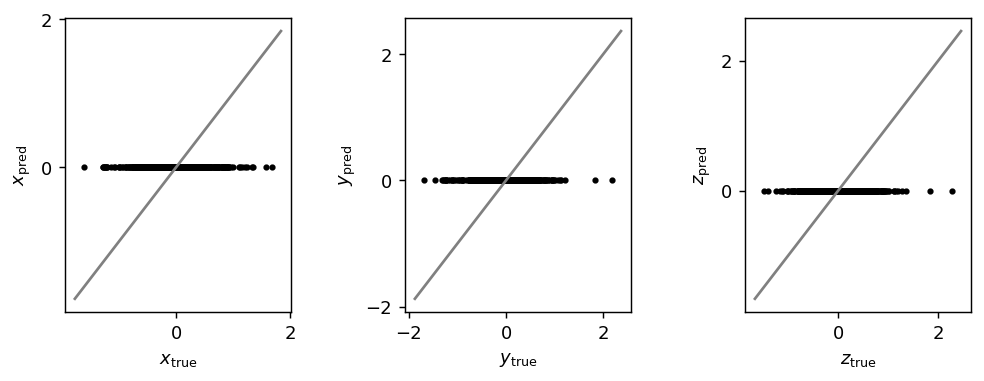

In [ ]:
fig, axarr = plt.subplots(1,3,figsize=(9,3))
plt.subplots_adjust(wspace=0.5)
ax_x = axarr[0]
ax_y = axarr[1]
ax_z = axarr[2]

zeros = np.zeros(n_test)
ax_x.scatter(y_vector_test_rolled[:,0], zeros, color='k', s=6)
ax_x.set_xlabel(r'$x_\mathrm{true}$')
ax_x.set_ylabel(r'$x_\mathrm{pred}$')

ax_y.scatter(y_vector_test_rolled[:,1], zeros, color='k', s=6)
ax_y.set_xlabel(r'$y_\mathrm{true}$')
ax_y.set_ylabel(r'$y_\mathrm{pred}$')

ax_z.scatter(y_vector_test_rolled[:,2], zeros, color='k', s=6)
ax_z.set_xlabel(r'$z_\mathrm{true}$')
ax_z.set_ylabel(r'$z_\mathrm{pred}$')

#true_line = np.linspace(m_minmin-0.2*m_spread, m_maxmax+0.2*m_spread)
for ax in axarr:
  true_line = np.linspace(*ax.get_xlim())
  ax.plot(true_line, true_line, color='grey')
  #ax.set_aspect('equal')
  ax.locator_params(axis="x", nbins=3)
  ax.locator_params(axis="y", nbins=3)

save_fn = f'x_coordinate_recovery{save_tag}.pdf'
if save_plots:
  plt.savefig(f"{plot_dir}/{save_fn}", bbox_inches='tight')

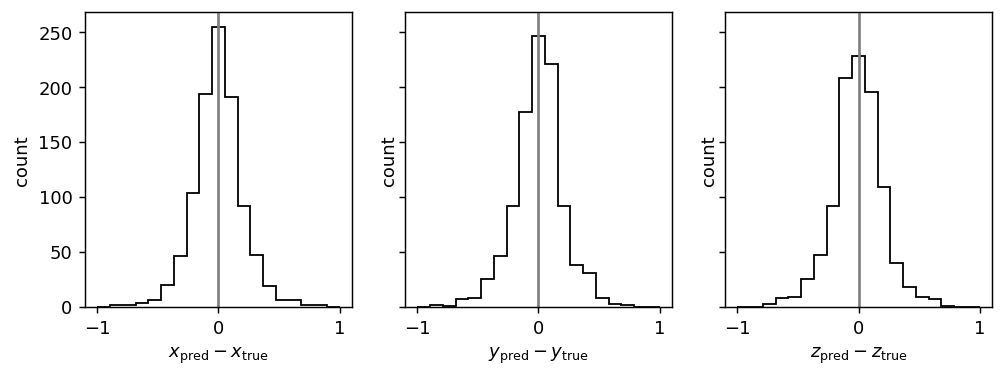

In [ ]:
fig, axarr = plt.subplots(1,3,sharey=True,figsize=(9,3))
plt.subplots_adjust(wspace=0.2)
ax_x = axarr[0]
ax_y = axarr[1]
ax_z = axarr[2]

#print([np.abs(np.min(y_vector_test_rolled.flatten())), np.max(y_vector_test_rolled.flatten()))])
delta_y = (y_vector_test_rolled- y_vector_pred_rolled).flatten()
edge_val = np.max([np.abs(np.min(delta_y)), np.max(delta_y)])
if edge_val>2:
  edge_val = 1
bins = np.linspace(-edge_val, edge_val, 20)

ax_x.hist(y_vector_pred_rolled[:,0] - y_vector_test_rolled[:,0], bins=bins, color='k', histtype='step')
ax_x.set_xlabel(r'$x_\mathrm{pred} - x_\mathrm{true}$')

ax_y.hist(y_vector_pred_rolled[:,1] - y_vector_test_rolled[:,1], bins=bins, color='k', histtype='step')
ax_y.set_xlabel(r'$y_\mathrm{pred} - y_\mathrm{true}$')

ax_z.hist(y_vector_pred_rolled[:,2] - y_vector_test_rolled[:,2], bins=bins, color='k', histtype='step')
ax_z.set_xlabel(r'$z_\mathrm{pred} - z_\mathrm{true}$')

for ax in axarr:
  ax.axvline(0, color='grey')
  ax.set_ylabel('count')


save_fn = f'x_coordinate_recovery_histogram{save_tag}.pdf'
if save_plots:
  plt.savefig(f"{plot_dir}/{save_fn}", bbox_inches='tight')